In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Tree Based Models

from operator import itemgetter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

# Linear Regression Based Models

from sklearn.linear_model import ElasticNet, HuberRegressor, LinearRegression, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor

# Metrics

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Parallel

from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from dask_ml.model_selection import GridSearchCV

# Helper functions

from feature_selection_helper import norm_cols 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
stk = pd.read_csv("../data/train_processed_upsampled2.csv")
stk.head()

,stroke_in_2018,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
stk.shape

(39592, 33)

In [4]:
stk.describe()

,stroke_in_2018,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
count,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,...,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.0
mean,0.166650,112.245483,31.132765,49.073276,0.899424,0.100576,0.428041,0.376642,0.174707,0.309229,...,0.533845,0.122095,0.283972,0.355148,0.238786,0.542938,0.298874,0.151217,0.006971,0.0
std,0.372668,46.361023,7.476227,23.401855,0.300770,0.300770,0.494801,0.484550,0.379721,0.462182,...,0.498859,0.327400,0.450929,0.478564,0.426347,0.498159,0.457770,0.358265,0.083203,0.0
min,0.000000,59.600000,12.600000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,82.290000,26.100000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,96.980000,30.400000,51.469315,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,120.170000,35.200000,68.659560,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
max,1.000000,295.650000,99.900000,85.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [5]:
X = stk.drop(labels="stroke_in_2018", axis=1).reset_index(drop=True)
y = stk["stroke_in_2018"].reset_index(drop=True)

In [6]:
X.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: stroke_in_2018, dtype: int64

Let's normalise the variables and see if that helps

In [8]:
X_norm = X.copy()

In [9]:
norm_cols(X_norm, ["average_blood_sugar", "BMI", "age_corr"])

In [10]:
X_norm.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0.051133,0.274914,0.707317,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.204829,0.203895,0.329268,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.071553,0.337915,0.585366,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.230375,0.512027,0.621951,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.046600,0.161512,0.292683,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Checking Feature Correlation

Because we have done so much feature engineering, we should remove some of the features that are likely to be correlated. First, we check this with a correlation heatmap.

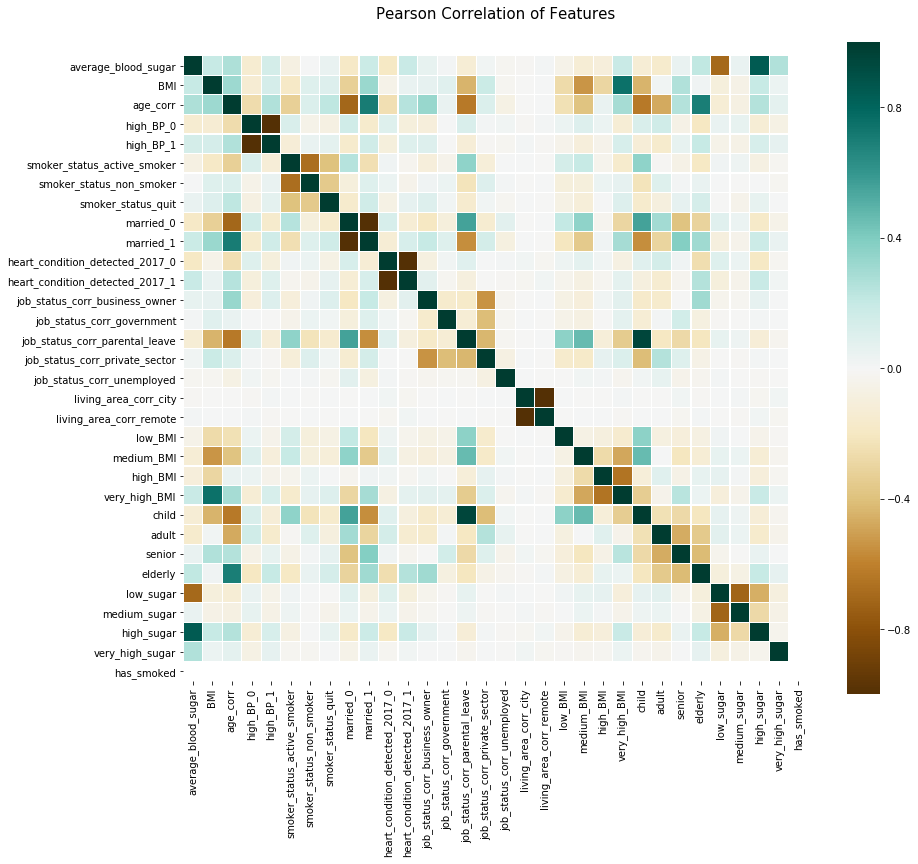

In [11]:
colormap = plt.cm.BrBG
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_norm.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white')

### Building Base Models

Now we proceed to build base models. We will consider:

- KNN-models, SVM (with penalised regression)
- Linear regression family (OLS, Lasso, Ridge, ElasticNet etc.)
- Tree-based (XGBoost, LGB, RandomForest etc.)

We will look at the ROC-AUC curve to determine the best model, and the F1-score, which considers both precision and recall

### Tree Based Models

In [12]:
tree_based_models = {
    "dt": DecisionTreeRegressor(),
    "rf": RandomForestRegressor(),
    "ada": AdaBoostRegressor(),
    "gb": GradientBoostingRegressor(),
    "et": ExtraTreesRegressor(),
    "xgb": XGBRegressor()
}

Because we are not yet interested in validation, we do not conduct any cross-validation when training the models. The purpose of this is to identify features which are important for 

In [13]:
for _, clf in tree_based_models.items():
    clf.fit(X_norm, y)

[01:54:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [14]:
def generate_sorted_feature_importance(columns_name, feature_importances):
    feature_importance_map = {}
    for i in range(len(columns_name)):
        feature_importance_map[columns_name[i]] = feature_importances[i]
    sorted_feature_importance = dict(sorted(feature_importance_map.items(), key=itemgetter(1)))
    return sorted_feature_importance

def plot_feature_importance(sorted_feature_importance, ax, title):
    num_feature = 20
    bp = sns.barplot(list(sorted_feature_importance.keys())[-num_feature:], list(sorted_feature_importance.values())[-num_feature:], ax=ax)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    bp.set_title(title)
    return bp

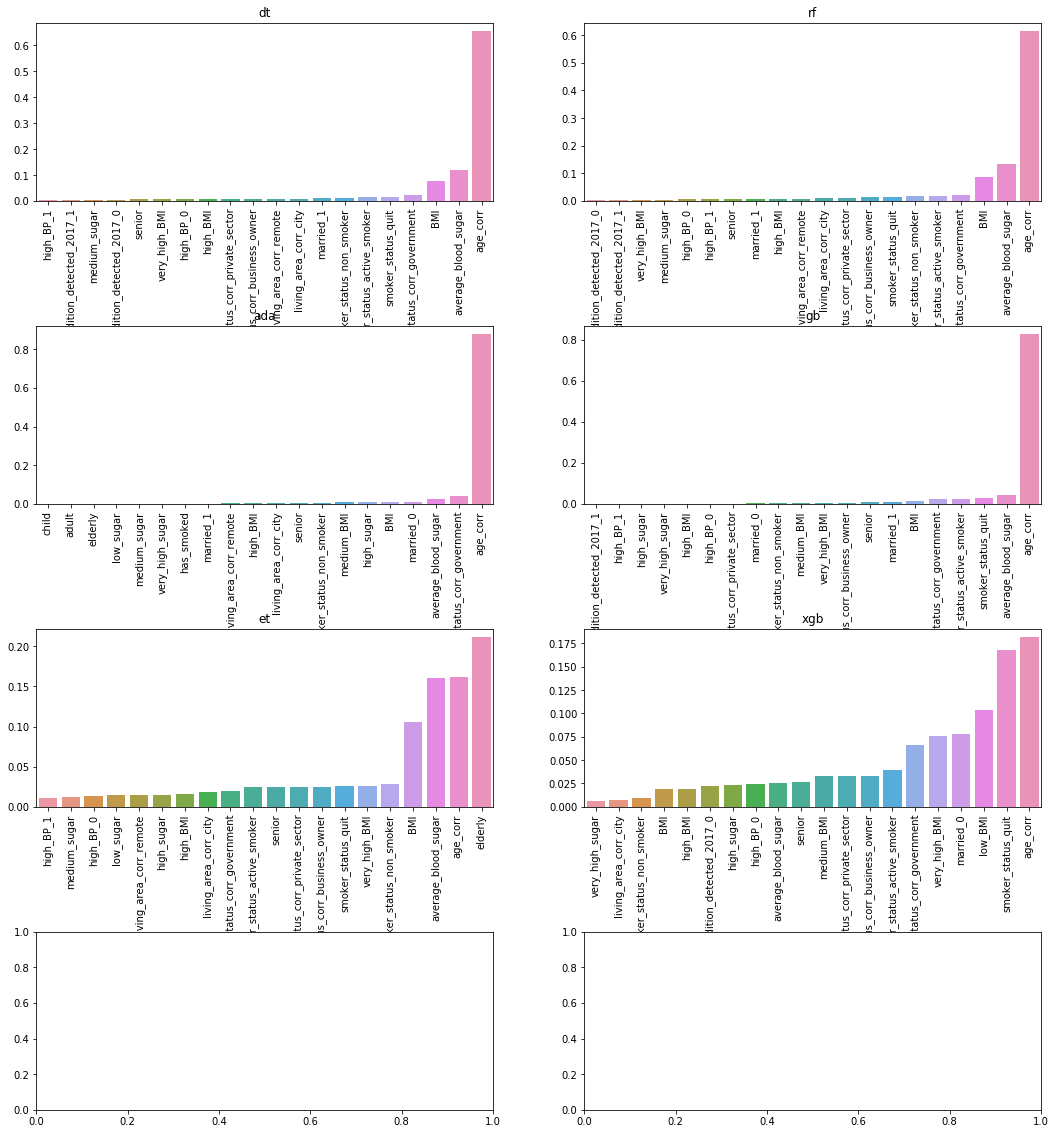

In [15]:
# to visualize the 20 most important features of each tree-based models
fig, axes = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.7)
count = 0
for name, clf in tree_based_models.items():
    row = count // 2
    column = count % 2
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    plot_feature_importance(sorted_feature_importance, axes[row, column], name)
    count += 1

In [16]:
clf_features_importance = pd.DataFrame()
for name, clf in tree_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [17]:
clf_features_importance[-10:]

,dt,rf,ada,gb,et,xgb
22,living_area_corr_remote,living_area_corr_city,living_area_corr_city,very_high_BMI,senior,medium_BMI
23,living_area_corr_city,job_status_corr_private_sector,senior,job_status_corr_business_owner,job_status_corr_private_sector,job_status_corr_private_sector
24,married_1,job_status_corr_business_owner,smoker_status_non_smoker,senior,job_status_corr_business_owner,job_status_corr_business_owner
25,smoker_status_non_smoker,smoker_status_quit,medium_BMI,married_1,smoker_status_quit,smoker_status_active_smoker
26,smoker_status_active_smoker,smoker_status_non_smoker,high_sugar,BMI,very_high_BMI,job_status_corr_government
27,smoker_status_quit,smoker_status_active_smoker,BMI,job_status_corr_government,smoker_status_non_smoker,very_high_BMI
28,job_status_corr_government,job_status_corr_government,married_0,smoker_status_active_smoker,BMI,married_0
29,BMI,BMI,average_blood_sugar,smoker_status_quit,average_blood_sugar,low_BMI
30,average_blood_sugar,average_blood_sugar,job_status_corr_government,average_blood_sugar,age_corr,smoker_status_quit
31,age_corr,age_corr,age_corr,age_corr,elderly,age_corr


In [18]:
for _, clf in tree_based_models.items():
    clf.fit(X, y)

[01:54:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
clf_features_importance = pd.DataFrame()
for name, clf in tree_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [20]:
clf_features_importance[-10:]

,dt,rf,ada,gb,et,xgb
22,married_0,living_area_corr_remote,senior,very_high_BMI,job_status_corr_government,medium_BMI
23,job_status_corr_business_owner,job_status_corr_private_sector,living_area_corr_remote,job_status_corr_business_owner,job_status_corr_private_sector,job_status_corr_private_sector
24,living_area_corr_city,job_status_corr_business_owner,BMI,married_1,very_high_BMI,job_status_corr_business_owner
25,smoker_status_quit,smoker_status_quit,smoker_status_non_smoker,senior,smoker_status_quit,smoker_status_active_smoker
26,smoker_status_active_smoker,smoker_status_non_smoker,married_0,BMI,smoker_status_active_smoker,job_status_corr_government
27,smoker_status_non_smoker,job_status_corr_government,high_sugar,job_status_corr_government,smoker_status_non_smoker,very_high_BMI
28,job_status_corr_government,smoker_status_active_smoker,medium_BMI,smoker_status_active_smoker,BMI,married_0
29,BMI,BMI,average_blood_sugar,smoker_status_quit,average_blood_sugar,low_BMI
30,average_blood_sugar,average_blood_sugar,job_status_corr_government,average_blood_sugar,age_corr,smoker_status_quit
31,age_corr,age_corr,age_corr,age_corr,elderly,age_corr


In [21]:
list(clf_features_importance[-5:].stack().value_counts().items())

[('age_corr', 6),
 ('average_blood_sugar', 5),
 ('job_status_corr_government', 4),
 ('BMI', 3),
 ('smoker_status_quit', 2),
 ('smoker_status_non_smoker', 2),
 ('smoker_status_active_smoker', 2),
 ('medium_BMI', 1),
 ('married_0', 1),
 ('high_sugar', 1),
 ('elderly', 1),
 ('low_BMI', 1),
 ('very_high_BMI', 1)]

In [22]:
[key for key, val in clf_features_importance[-10:].stack().value_counts().items() if val == 6]

['job_status_corr_government', 'age_corr']

We check up to the $i^{th}$ most important feature, and take the attributes present in all 6 models. 

In [23]:
tree_sc = []
tree_iterations = list(range(5, 33))
for i in tree_iterations:
    tree_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 6]
    clf = GradientBoostingRegressor()
    score = np.mean(cross_val_score(clf, X_norm.loc[:, tree_model_selected_features], y, cv=5, scoring="roc_auc"))
    tree_sc.append(score)

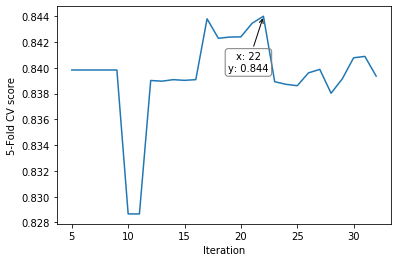

In [24]:
fig, axes = plt.subplots()
sns.lineplot(tree_iterations, tree_sc, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = tree_iterations[tree_sc.index(max(tree_sc))]
max_y_loc = max(tree_sc)
axes.annotate(
    "x: {}\ny: {:.3f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(-15, -55), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

In [25]:
tree_model_best_features = [key for key, val in clf_features_importance[-17:].stack().value_counts().items() if val == 6]
tree_model_best_features

['BMI',
 'high_BMI',
 'average_blood_sugar',
 'age_corr',
 'job_status_corr_government']

<div class="alert alert-block alert-warning">
The important features are listed above. It is surprising that `elderly` is not on the list. However, `senior` is, which suggests that perhaps the effect of `elderly` is being masked by one of the other variables
</div>

### Linear Regression Based Models

In [26]:
linear_based_models = {
    "en": ElasticNet(),
    "hr": HuberRegressor(),
    "lr": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "sgd": SGDRegressor(), 
    "pa": PassiveAggressiveRegressor()
}

In [27]:
# train all the models at once
for _, clf in linear_based_models.items():
    clf.fit(X, y)

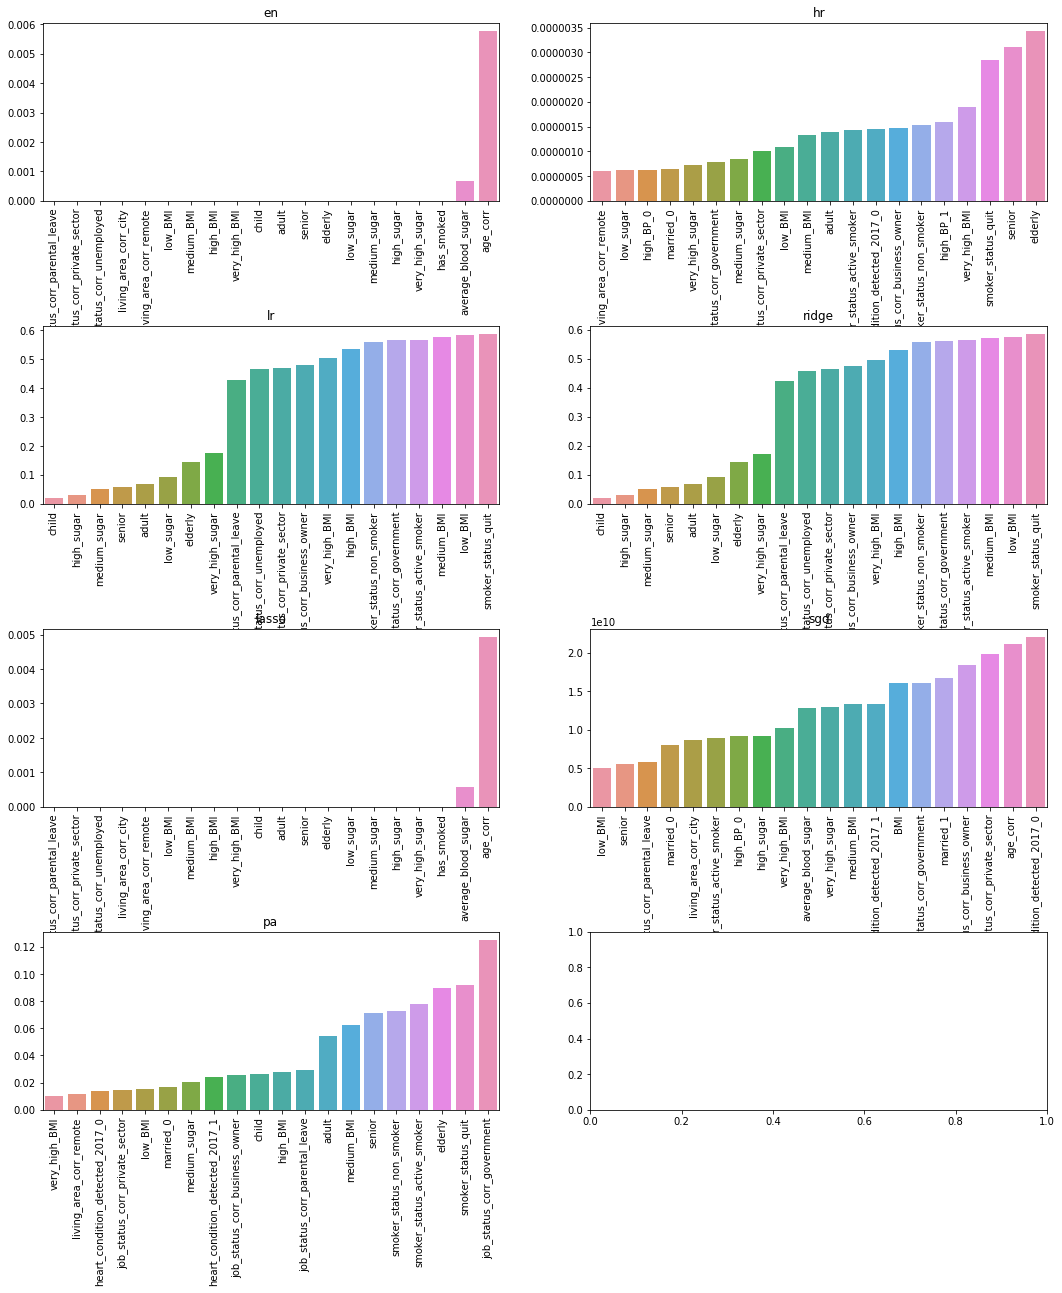

In [28]:
# to visualize the 20 most important features of each linear-based models
fig, axes = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.7)
count = 0
for name, clf in linear_based_models.items():
    row = count // 2
    column = count % 2
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, np.abs(clf.coef_)) # noted here we use the absolute value of coefficient
    plot_feature_importance(sorted_feature_importance, axes[row, column], name)
    count += 1

In [51]:
linear_model_selected_features

['low_sugar',
 'job_status_corr_government',
 'medium_sugar',
 'smoker_status_non_smoker',
 'high_BMI',
 'child',
 'BMI',
 'age_corr',
 'married_0',
 'medium_BMI',
 'smoker_status_quit',
 'adult',
 'job_status_corr_unemployed',
 'job_status_corr_business_owner',
 'job_status_corr_parental_leave',
 'has_smoked',
 'elderly',
 'job_status_corr_private_sector',
 'smoker_status_active_smoker',
 'very_high_BMI',
 'low_BMI',
 'high_BP_1',
 'very_high_sugar',
 'high_BP_0',
 'senior',
 'heart_condition_detected_2017_1',
 'heart_condition_detected_2017_0',
 'living_area_corr_remote',
 'average_blood_sugar',
 'high_sugar',
 'married_1',
 'living_area_corr_city']

In [29]:
linear_sc = []
linear_iteration = list(range(5, 33))
for i in linear_iteration:
    linear_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 6]
    clf = LinearRegression()
    score = np.mean(cross_val_score(clf, X.loc[:, linear_model_selected_features], y, cv=5, scoring="roc_auc"))
    linear_sc.append(score)

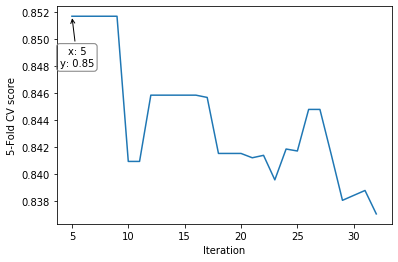

In [30]:
fig, axes = plt.subplots()
sns.lineplot(linear_iteration, linear_sc, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = linear_iteration[linear_sc.index(max(linear_sc))]
max_y_loc = max(linear_sc)
axes.annotate(
    "x: {}\ny: {:.2f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(5, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

In [31]:
linear_model_best_features = [key for key, val in clf_features_importance[-5:].stack().value_counts().items() if val == 6]
linear_model_best_features


['age_corr']

<div class="alert alert-block alert-warning">
It appears that for linear regression models, `age_corr` is the only variable with strong predictive power. 
</div>

### Finding the Best Model

Now we take a cross-validation approach with both tree and linear models. We use stratified CV to ensure that the ratio of classes are balanced. 

In [32]:
client = Client()
kf = StratifiedKFold(n_splits=5, random_state=99)

In [34]:
def get_cv_score(clf, X, y, kf):
    cv_scores = []
    with parallel_backend("dask"):
        for _, (train_index, test_index) in enumerate(kf.split(X, y)):
            train_X, train_y = X.loc[train_index], y[train_index] 
            # up sampling the train data
#             train_X, train_y = smote.fit_sample(train_X, train_y)
            test_X, test_y = X.loc[test_index], y[test_index]

            clf.fit(train_X, train_y)
            y_pred = clf.predict(test_X)
            score = roc_auc_score(test_y, y_pred)
            cv_scores.append(score)
        return np.mean(cv_scores)

In [36]:
tree_cv_scores_norm = []
for _, clf in tree_based_models.items():
    cv_score_norm = get_cv_score(clf, X_norm.loc[:, tree_model_best_features], y, kf)
    tree_cv_scores_norm.append(cv_score_norm)

[01:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
pd.DataFrame({"classifiers": list(tree_based_models.keys()), 
              "CV score": tree_cv_scores_norm}).sort_values("CV score")

,classifiers,CV score
2,ada,0.874278
0,dt,0.915863
5,xgb,0.932193
3,gb,0.932641
1,rf,0.965398
4,et,0.977740


In [38]:
tree_cv_scores = []
for _, clf in tree_based_models.items():
    cv_score = get_cv_score(clf, X.loc[:, tree_model_best_features], y, kf)
    tree_cv_scores.append(cv_score)

[01:59:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [39]:
pd.DataFrame({"classifiers": list(tree_based_models.keys()), 
              "CV score": tree_cv_scores}).sort_values("CV score")

,classifiers,CV score
2,ada,0.874746
0,dt,0.917030
5,xgb,0.932194
3,gb,0.932643
1,rf,0.965939
4,et,0.977305


Because linear regression only chooses 1 feature, we're going to use all of them. It appears that using more features gives better results in this case

In [40]:
linear_cv_scores = []
for _, clf in linear_based_models.items():
    cv_score = get_cv_score(clf, X.loc[:, linear_model_selected_features], y, kf)
    linear_cv_scores.append(cv_score)

In [41]:
pd.DataFrame({"classifiers": list(linear_based_models.keys()), 
              "CV score": linear_cv_scores}).sort_values("CV score")

,classifiers,CV score
5,sgd,0.411840
1,hr,0.819929
6,pa,0.835965
0,en,0.857939
4,lasso,0.858239
2,lr,0.894991
3,ridge,0.895001


In [42]:
from copy import deepcopy

class StackingRegressor:
    def __init__(self, models, second_model, features):
        self.models = models
        self.feature_models = []
        self.second_model = second_model
        self.features = features
    
    def _generate_f_features(self, X):
        f_features = np.zeros((X.shape[0], len(self.features) * len(self.models)))
        for num, features in enumerate(self.features * len(self.models)):
            model = self.feature_models[num]
            f_features[:, num] = model.predict(X.loc[:, features[1]])
        return f_features
    
    def fit(self, X, y):
        # generate multiple trained models with different features
        for model in self.models:
            for feature in self.features:
                model.fit(X.loc[:, feature[1]], y)
                self.feature_models.append(deepcopy(model))
        f_features = self._generate_f_features(X)
        self.second_model.fit(f_features, y)
    
    def predict(self, X):
        f_features = self._generate_f_features(X)
        return self.second_model.predict(f_features)

In [43]:
features = [
    ("tree", tree_model_best_features),
    ("linear", linear_model_selected_features)
]

In [52]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
                    ElasticNet(), Ridge(), Lasso()], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[02:08:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:08:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:08:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:08:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:08:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9616899942751667


In [54]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[02:09:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:09:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:10:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9691237995020823


In [56]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
                    Lasso(), LinearRegression(), Ridge()
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[02:11:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:11:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:11:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9713101043253924


In [61]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(),
                    Lasso(), LinearRegression(), PassiveAggressiveRegressor()
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[02:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9763663800209065


In [57]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), 
                    Lasso(), LinearRegression(), PassiveAggressiveRegressor()
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[02:12:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9685603764574063


In [59]:
# print(get_cv_score(StackingRegressor([
#                     GradientBoostingRegressor(), RandomForestRegressor(),
#                     Lasso(), LinearRegression(), PassiveAggressiveRegressor()
#             ], 
#     XGBRegressor(), features), X_norm, y, kf)
#      )

print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), 
                    Lasso(), LinearRegression(), Ridge()
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

# print(get_cv_score(StackingRegressor([
#                     GradientBoostingRegressor(), RandomForestRegressor(), 
#                     Lasso(), LinearRegression(), PassiveAggressiveRegressor()
#             ], 
#     XGBRegressor(), features), X_norm, y, kf)
#      )

[02:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9669089095225631


In [60]:
get_cv_score(StackingRegressor([
                    ExtraTreesRegressor(), RandomForestRegressor(), 
                    Lasso(), Ridge()
            ], 
    XGBRegressor(), features), X_norm, y, kf)

[02:14:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9674392240330262

In [67]:
best_models = [
    GradientBoostingRegressor(), RandomForestRegressor(),
    Lasso(), LinearRegression(), PassiveAggressiveRegressor()
]

### Visualising the ROC Curve

We do a simple split and train on the optimal model we found from above and check the ROC curve.

In [46]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [68]:
sr = StackingRegressor(best_models, GradientBoostingRegressor(), features)
sr.fit(train_X, train_y) # this was created in section 1.5.1
y_pred = sr.predict(test_X)

In [71]:
y_pred

array([-8.03442582e-05,  1.49673611e-05,  1.49673611e-05, ...,
        1.49673611e-05,  9.91109256e-01,  1.49673611e-05])

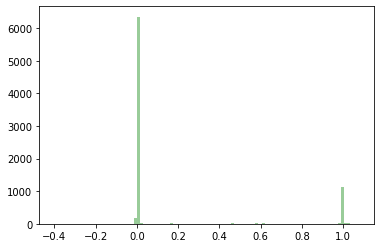

In [72]:
sns.distplot(y_pred, kde = False, bins = 100, color = "green")

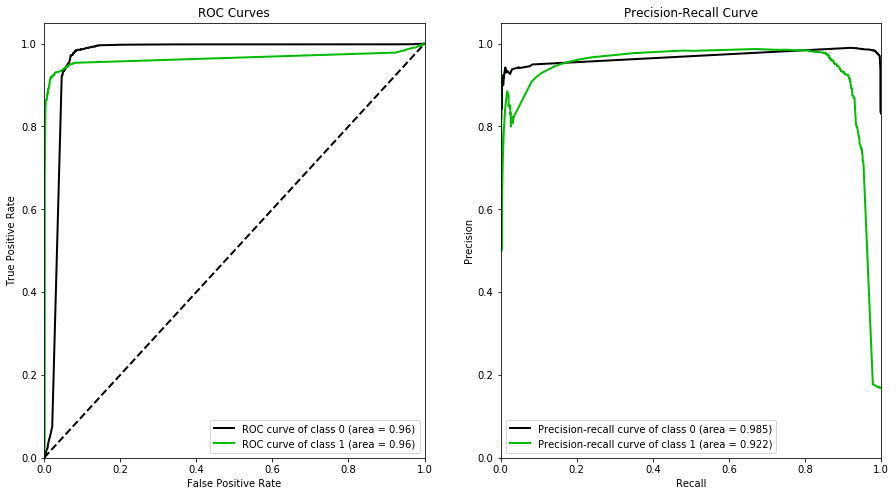

In [69]:
import scikitplot as skplt

fig, axes = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
skplt.metrics.plot_roc(test_y, np.column_stack((1-y_pred, y_pred)), plot_macro=False, plot_micro=False, ax=axes[0])
skplt.metrics.plot_precision_recall(test_y, np.column_stack((1-y_pred, y_pred)), plot_micro=False, ax=axes[1])

In [70]:
y_result = np.where(y_pred > 0.5, 1, 0)
print(classification_report(test_y, y_result, digits=3))

              precision    recall  f1-score   support

           0      0.979     0.987     0.983      6581
           1      0.934     0.895     0.914      1338

    accuracy                          0.972      7919
   macro avg      0.956     0.941     0.949      7919
weighted avg      0.971     0.972     0.971      7919



### Sandbox Code

code below was for experimentation and may break if you run itm